In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import random

In [10]:
import random
import time

BOARDWIDTH = 10
BOARDHEIGHT = 20
BLANK = 0

TEMPLATEWIDTH = 5
TEMPLATEHEIGHT = 5

S_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '..OO.',
                     '.OO..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '...O.',
                     '.....']]

Z_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '.O...',
                     '.....']]

I_SHAPE_TEMPLATE = [['..O..',
                     '..O..',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     'OOOO.',
                     '.....',
                     '.....']]

O_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '.OO..',
                     '.....']]

J_SHAPE_TEMPLATE = [['.....',
                     '.O...',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..OO.',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '...O.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '.OO..',
                     '.....']]

L_SHAPE_TEMPLATE = [['.....',
                     '...O.',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '.O...',
                     '.....'],
                    ['.....',
                     '.OO..',
                     '..O..',
                     '..O..',
                     '.....']]

T_SHAPE_TEMPLATE = [['.....',
                     '..O..',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '..O..',
                     '.....']]

PIECES = {'S': S_SHAPE_TEMPLATE,
          'Z': Z_SHAPE_TEMPLATE,
          'J': J_SHAPE_TEMPLATE,
          'L': L_SHAPE_TEMPLATE,
          'I': I_SHAPE_TEMPLATE,
          'O': O_SHAPE_TEMPLATE,
          'T': T_SHAPE_TEMPLATE}

def initializegame():
    board = getBlankBoard()
    movingDown = False # note: there is no movingUp variable
    movingLeft = False
    movingRight = False

    fallingPiece = getNewPiece()
    nextPiece = getNewPiece()
    state=(board, fallingPiece, nextPiece)
    return (state, 0, False)

def onestep(state, action):
    board, fallingPiece, nextPiece = state
    
    if not isValidPosition(board, fallingPiece):
        # Game is finished. Return
        return (state, 0, True)

    movingLeft=False
    movingRight=False
    movingDown=False

    # moving the piece sideways
    if action == 'L' and isValidPosition(board, fallingPiece, adjX=-1):
        fallingPiece['x'] -= 1
        movingLeft = True

    elif action == 'R' and isValidPosition(board, fallingPiece, adjX=1):
        fallingPiece['x'] += 1
        movingRight = True

    # rotating the piece (if there is room to rotate)
    elif action == 'W':
        fallingPiece['rotation'] = (fallingPiece['rotation'] + 1) % len(PIECES[fallingPiece['shape']])
        if not isValidPosition(board, fallingPiece):
            fallingPiece['rotation'] = (fallingPiece['rotation'] - 1) % len(PIECES[fallingPiece['shape']])
    elif action == 'Q': # rotate the other direction
        fallingPiece['rotation'] = (fallingPiece['rotation'] - 1) % len(PIECES[fallingPiece['shape']])
        if not isValidPosition(board, fallingPiece):
            fallingPiece['rotation'] = (fallingPiece['rotation'] + 1) % len(PIECES[fallingPiece['shape']])

    # making the piece fall faster with the down key
    elif action == 'D':
        movingDown = True
        if isValidPosition(board, fallingPiece, adjY=1):
            fallingPiece['y'] += 1

    # move the current piece all the way down
    elif action == 'S':
        for i in range(1, BOARDHEIGHT):
            if not isValidPosition(board, fallingPiece, adjY=i):
                break
        fallingPiece['y'] += i - 1
        
    if not isValidPosition(board, fallingPiece, adjY=1):
        # falling piece has landed, set it on the board
        addToBoard(board, fallingPiece)
        reward = removeCompleteLines(board)
        fallingPiece = nextPiece
        nextPiece = getNewPiece()
    else:
        # piece did not land, just move the piece down
        fallingPiece['y'] += 1
        reward = 0
        
    
    state=(board, fallingPiece, nextPiece)
    return (state, reward, False)

def getNewPiece():
    # return a random new piece in a random rotation and color
    shape = random.choice(list(PIECES.keys()))
    newPiece = {'shape': shape,
                'rotation': random.randint(0, len(PIECES[shape]) - 1),
                'x': int(BOARDWIDTH / 2) - int(TEMPLATEWIDTH / 2),
                'y': -2, # start it above the board (i.e. less than 0)
                'color': random.randint(1, 10)}
    return newPiece

def addToBoard(board, piece):
    # fill in the board based on piece's location, shape, and rotation
    for x in range(TEMPLATEWIDTH):
        for y in range(TEMPLATEHEIGHT):
            if PIECES[piece['shape']][piece['rotation']][y][x] != '.':
                board[x + piece['x']][y + piece['y']] = piece['color']

def addToBoardinbound(board, piece):
    # fill in the board based on piece's location, shape, and rotation
    for x in range(TEMPLATEWIDTH):
        for y in range(TEMPLATEHEIGHT):
            if PIECES[piece['shape']][piece['rotation']][y][x] != '.' and y + piece['y'] >= 0:
                board[x + piece['x']][y + piece['y']] = piece['color']
                
def getBlankBoard():
    # create and return a new blank board data structure
    board = []
    for i in range(BOARDWIDTH):
        board.append([BLANK] * BOARDHEIGHT)
    return board


def isOnBoard(x, y):
    return x >= 0 and x < BOARDWIDTH and y < BOARDHEIGHT


def isValidPosition(board, piece, adjX=0, adjY=0):
    # Return True if the piece is within the board and not colliding
    for x in range(TEMPLATEWIDTH):
        for y in range(TEMPLATEHEIGHT):
            isAboveBoard = y + piece['y'] + adjY < 0
            if isAboveBoard or PIECES[piece['shape']][piece['rotation']][y][x] == '.':
                continue
            if not isOnBoard(x + piece['x'] + adjX, y + piece['y'] + adjY):
                return False
            if board[x + piece['x'] + adjX][y + piece['y'] + adjY] != BLANK:
                return False
    return True

def isCompleteLine(board, y):
    # Return True if the line filled with boxes with no gaps.
    for x in range(BOARDWIDTH):
        if board[x][y] == BLANK:
            return False
    return True


def removeCompleteLines(board):
    # Remove any completed lines on the board, move everything above them down, and return the number of complete lines.
    numLinesRemoved = 0
    y = BOARDHEIGHT - 1 # start y at the bottom of the board
    while y >= 0:
        if isCompleteLine(board, y):
            # Remove the line and pull boxes down by one line.
            for pullDownY in range(y, 0, -1):
                for x in range(BOARDWIDTH):
                    board[x][pullDownY] = board[x][pullDownY-1]
            # Set very top line to blank.
            for x in range(BOARDWIDTH):
                board[x][0] = BLANK
            numLinesRemoved += 1
            # Note on the next iteration of the loop, y is the same.
            # This is so that if the line that was pulled down is also
            # complete, it will be removed.
        else:
            y -= 1 # move on to check next row up
    return numLinesRemoved
        

TO DO:

    Package everything into a class
    class Tetris(self):
        ....
        ...
        ....
        
    Tetris.onestep(action)=(next state, reward, done)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:

                
def convertstatetoimg(state):
    board = state[0]
    fallingPiece = state[1]
    if fallingPiece == None:
        return board
    blank = getBlankBoard()
    addToBoardinbound(blank, fallingPiece)
    for i in range(len(board)):
        for j in range(len(board[0])):
            blank[i][j]+=board[i][j]

    return blank



def animate(state, Actions):
    
    %matplotlib
    
    fig = plt.gcf()
    fig.show()
    fig.canvas.draw()
    plt.grid()
    
    for j in range(len(Actions)):
        time.sleep(0.2)
        
        state, reward, done = onestep(state, Actions[j])
        if done:
            break
        fallingPieceShape = state[1]['shape']
        nextPieceShape = state[2]['shape']
        
        plt.title('Action: ' + Actions[j]+' ,Cur: '+fallingPieceShape+' ,Next: '+nextPieceShape)
        
        board = convertstatetoimg(state)

        plt.imshow(np.transpose(board), cmap=plt.cm.binary)
        width = len(board)
        height = len(board[0])
        plt.xlim(-0.5, width-0.5)
        plt.ylim(height-0.5, 0.5)
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, width-0.5, 1))
        ax.set_yticks(np.arange(0.5, height-0.5, 1))
        
        fig.canvas.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


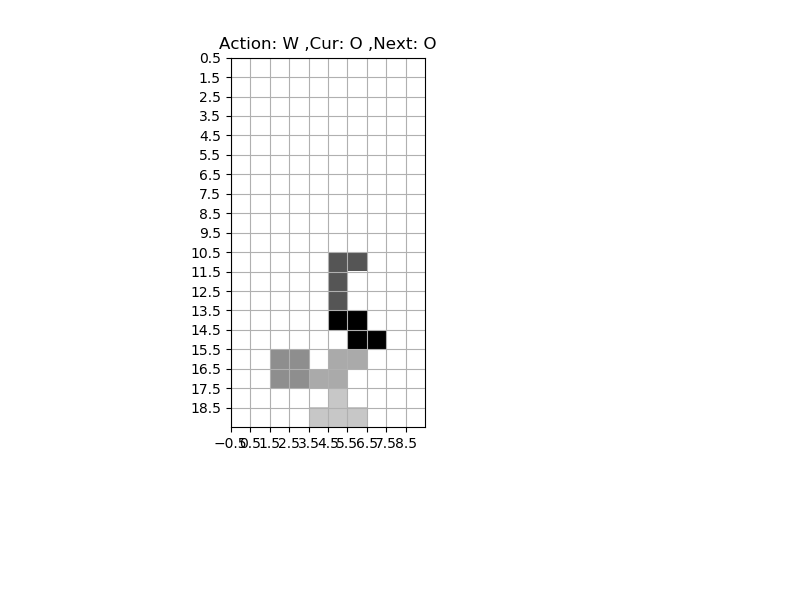

In [ ]:
random.seed(2)
state, reward, done = initializegame()
possibleActions = ['L', 'R', 'D', 'W', 'Q', 'S']
actionLength = 100
actions = [possibleActions[random.randint(0, len(possibleActions)-1)] for _ in range(actionLength)]

animate(state, actions)

In [ ]:
plt.imshow(np.transpose(state[0]), cmap=plt.cm.binary)
plt.show()